In [11]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12, 8]
matplotlib.rcParams.update({'font.size': 12})

In [12]:
def _seq_forward_selection(dataf, ycolumn, xcolumns, test_size, method, seed=99):
    """Sequential forward selection of available features based on holdout performance"""
    
    selected_full, selected_xcolumns = [], []
    while len(xcolumns) != len(selected_xcolumns):
        output_xcolumns, output_scores = [], []
        for f in xcolumns:
            if f not in selected_xcolumns:
                X = dataf[selected_xcolumns + [f]].values
                y = dataf[ycolumn].values
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                _score = _model(X_train, X_test, y_train, y_test, method, seed=seed)
                output_xcolumns.append(f)
                output_scores.append(_score)
        best_next_score = max(output_scores)
        best_index = output_scores.index(best_next_score)
        best_next_f = output_xcolumns[best_index]
        selected_full.append([len(selected_xcolumns + [best_next_f]), selected_xcolumns + [best_next_f], best_next_score])
        selected_xcolumns.append(best_next_f)

    return selected_full


def _model(X_train, X_test, y_train, y_test, method, seed=99):
    """Fit model and predict on test set"""
    
    if method == 'tree':
        classifier = DecisionTreeClassifier(random_state=seed)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
        
    if method == 'svm':
        classifier = LinearSVC(max_iter=100000, dual=True, random_state=seed)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
        
    if method == 'lg':
        classifier = LogisticRegression(random_state=seed, solver='sag', multi_class='ovr', max_iter=100000)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
        
    if method == 'randomforest':
        classifier = RandomForestClassifier(n_estimators=100, random_state=seed)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
        
    if method == 'boosting':
        params = {
            'n_estimators': 500,
            'max_depth': 4,
            'random_state': 10,
            'min_samples_split': 5,
            'learning_rate': 0.01,
        }
        classifier = GradientBoostingClassifier(**params)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test)
    
    return round(metrics.accuracy_score(y_test, y_predict), 7)

def execute_models(models):
    """Loop model execution on forward feature selection"""
    
    model_comparison = {}
    outputdfs = []
    for m in models:
        try:
            print(f'==> running {m}')
            output = _seq_forward_selection(df, ycolumn, xcolumns, test_size, method=m, seed=seed)
            dfoutput = pd.DataFrame(output, columns=['n_features', 'features', 'score'])
            dfoutput.index = dfoutput['n_features']
            outputdfs.append(dfoutput)
            max_score = dfoutput['score'].max()
            optimal_f_selection = dfoutput.loc[lambda x: x['score']==x['score'].max()].loc[lambda x: x['n_features']==x['n_features'].min()]['features'].values[0]
            model_comparison[m] = {
                'score': max_score,
                'n_features': len(optimal_f_selection),
                'features': optimal_f_selection
            }
        except:
            print(f'error occured during {m} model')
            pass
    
    return model_comparison, outputdfs

def tree_fit_score(X_train, y_train, X_test=None, y_test=None, n_nodes=None, use_testset=True, method=None):
    """Fit model on training data, and calculate accuracy based on training or test data"""
    
    if method == 'tree':
        classifier = DecisionTreeClassifier(max_depth=n_nodes, random_state=99)
    elif method == 'randomforest':
        classifier = RandomForestClassifier(n_estimators=100, max_depth=n_nodes, random_state=seed)
    classifier.fit(X_train, y_train)
    if use_testset == False:
        y_predict = classifier.predict(X_train)
        score = metrics.accuracy_score(y_train, y_predict)
    else:
        y_predict = classifier.predict(X_test)
        score = metrics.accuracy_score(y_test, y_predict)
    return score
    
def n_node_increase_scores(X_train, y_train, X_test, y_test, depth_range, method):
    """Get model accuracies for the given n nodes range"""
    
    rows = []
    for n in depth_range:
        _score_full = tree_fit_score(X_train, y_train, n_nodes=n, use_testset=False, method=method)
        _score_testtrain = tree_fit_score(X_train, y_train, X_test, y_test, n_nodes=n, method=method)
        rows.append([n, _score_full, _score_testtrain])
        
    return rows

def plot_fitting_graph(rows):
    """Plot n nodes accuracies based on both training and test data"""
    
    plt.plot([y[0] for y in rows], [y[1] for y in rows], label='train_performance', color='k')
    plt.plot([y[0] for y in rows], [y[2] for y in rows], label='test_performance', color='k', linestyle='dashed')
    plt.xticks(np.arange(1, max([y[0] for y in rows])+1, step=1))
    plt.title('Train & holdout performance vs tree depth')
    plt.legend()

## -- read in

In [13]:
df = pd.read_csv('input/final_featured_dataset.csv')

In [14]:
ycolumn = 'dealstatus'
xcolumns = [c for c in df.columns if c != ycolumn]
seed = 99
test_size = 0.2
models = ['tree', 'svm', 'lg', 'randomforest', 'boosting']

In [15]:
dealstatuscount = df.groupby(ycolumn)[[xcolumns[1]]].count()
dealstatuscount.columns = ['n_rows']
dealstatuscount['proba'] = round(dealstatuscount['n_rows'] / dealstatuscount['n_rows'].sum(), 2)
dealstatuscount

,n_rows,proba
dealstatus,,
0,282,0.5
1,282,0.5


## -- model testing and forward feature selection

In [7]:
model_comparison, outputdfs = execute_models(models)

==> running tree
==> running svm
==> running lg
==> running randomforest
==> running boosting


In [8]:
nowstamp = datetime.now().strftime('%Y%m%d%H%M%S')
with open(f'output/model_outputs_{nowstamp}.json', 'w') as stream:
    json.dump(model_comparison, stream)

In [16]:
with open('output/model_outputs_20210218144658.json', 'r') as stream:
    model_comparison = json.load(stream)

In [ ]:
count = 0
for m in models:
    plt.plot(outputdfs[count]['score'])
    count += 1
plt.title('n features vs holdout performance')
plt.legend(models)
plt.show()

## -- fitting graph plot for tree modeling

In [158]:
start_depth = 1
end_depth = 20
model_to_run = 'tree'

In [159]:
print('Selected features:')
for x in model_comparison[model_to_run]['features']:
    print(f'-- {x}')

Selected features:
-- deal_type_acquisition_100%
-- target_sector_other
-- same_country
-- target_sector_machinery
-- target_sector_transport
-- target_sector_food
-- target_sector_wholesale
-- target_sector_gas
-- acquiror_sector_gas
-- target_sector_metals
-- acquiror_sector_metals


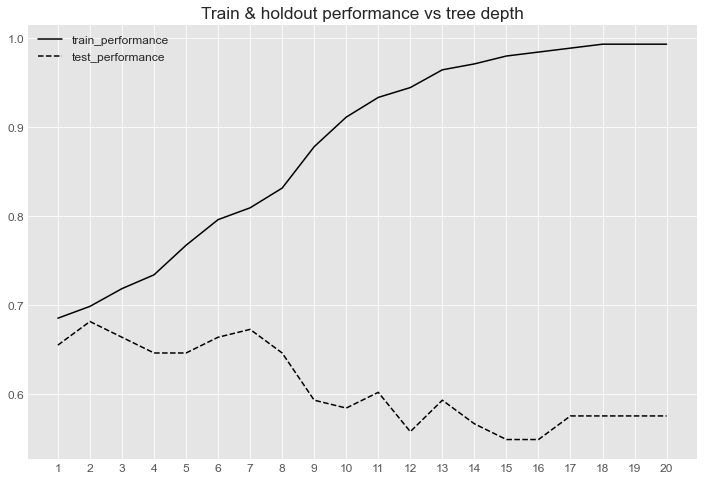

In [168]:
xcolumns = [c for c in df.columns if c != ycolumn]
X = df[xcolumns].values
y = df[ycolumn].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scores = n_node_increase_scores(X_train, y_train, X_test, y_test, range(start_depth, end_depth+1), model_to_run)
plot_fitting_graph(scores)

## -- model explanation & feature importance

### tree classification

In [25]:
model_to_run = 'tree'
selected_features = model_comparison[model_to_run]['features']
X = df[selected_features].values
y = df[ycolumn].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
if model_to_run == 'tree':
    classifier = DecisionTreeClassifier(max_depth=7, min_samples_leaf=1, random_state=seed)
elif model_to_run == 'randomforest':
    classifier = RandomForestClassifier(max_depth=7, n_estimators=100, random_state=seed)
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)
score = round(metrics.accuracy_score(y_test, y_predict), 7)

In [26]:
print(f'Accuracy score of {model_to_run} model {round(score, 3)*100}%')

Accuracy score of tree model 71.7%


<module 'sklearn.tree' from '/Users/simonvreugdenhil/dev/uva-strategy-analytics/venv/lib/python3.8/site-packages/sklearn/tree/__init__.py'>

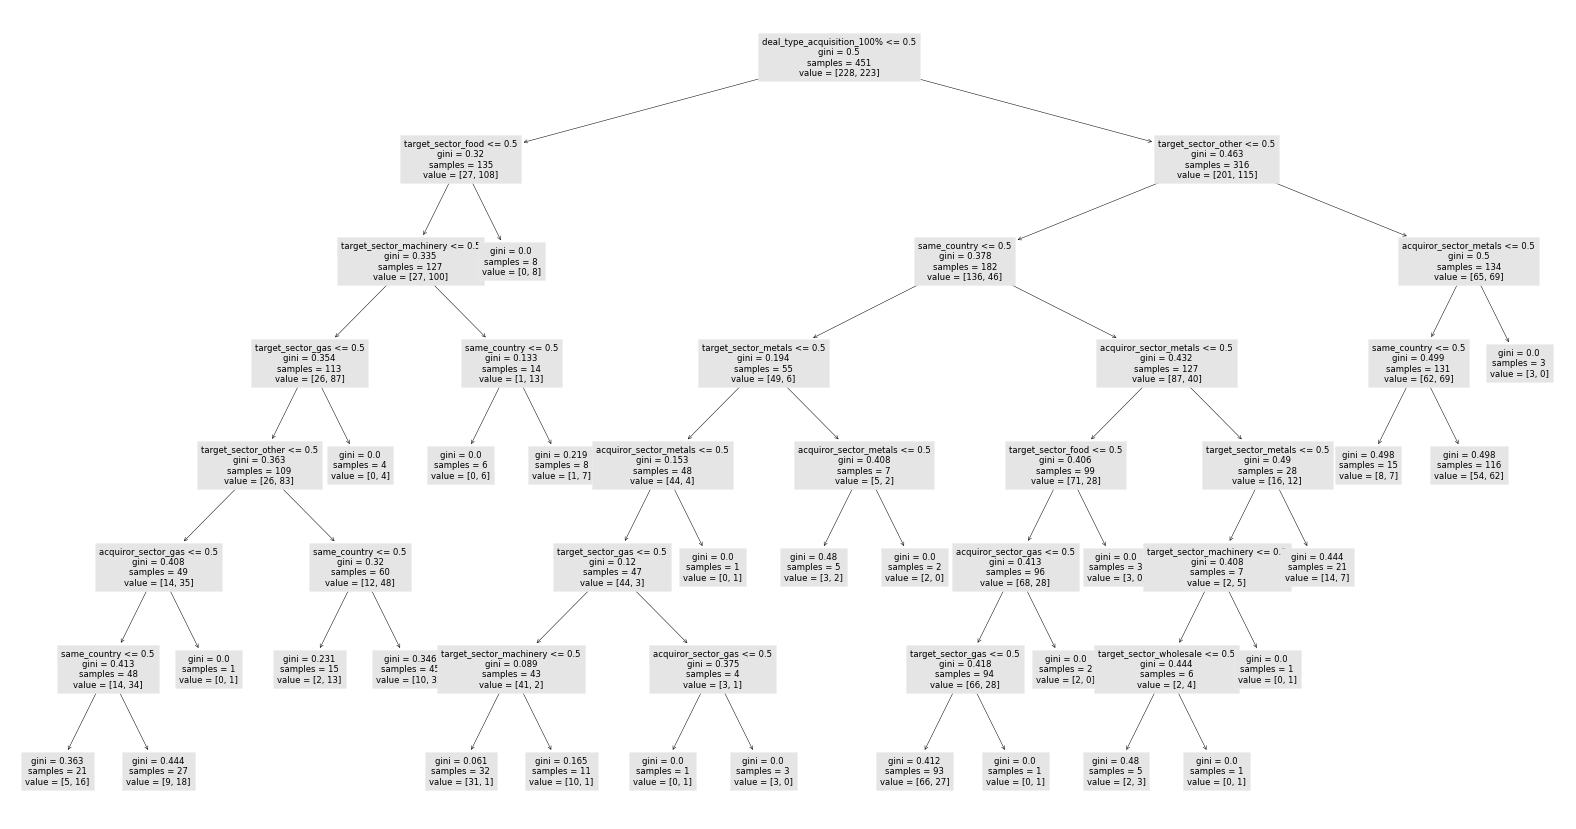

In [27]:
plt.figure(figsize=(28,15))
if model_to_run == 'tree':
    tree.plot_tree(classifier, feature_names=selected_features, fontsize=8.5)
elif model_to_run == 'randomforest':
    tree.plot_tree(classifier.estimators_[0], feature_names=selected_features, fontsize=9)
tree

In [28]:
dfconfusion = pd.DataFrame({
    'y_predict': y_predict,
    'y_test': y_test,
             })
dfconfusion['count'] = 1
dfx = dfconfusion.groupby(['y_predict', 'y_test'], as_index=False)[['count']].sum()
for z in [0, 1]:
    dfx.loc[lambda x: x['y_predict']==z, 'percent'] = round(dfx.loc[lambda x: x['y_predict']==z]['count'] / dfx.loc[lambda x: x['y_predict']==z]['count'].sum(), 3)
#dfx

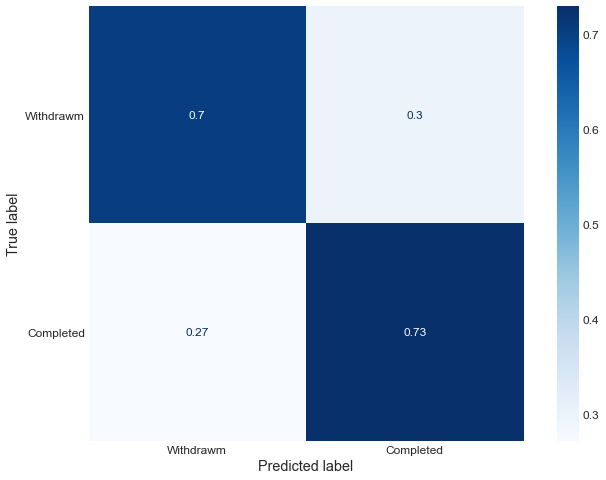

In [29]:
from sklearn.metrics import plot_confusion_matrix
plt.style.use("seaborn-dark")

pltconf = plot_confusion_matrix(classifier,
                                X_test,
                                y_test,
                                display_labels=['Withdrawm', 'Completed'],
                                cmap=plt.cm.Blues,
                                normalize='true')
pltconf

### linear model

In [177]:
model_to_run = 'svm'
selected_features = model_comparison['tree']['features']
X = df[selected_features].values
y = df[ycolumn].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
classifier = LinearSVC(max_iter=100000, dual=True, random_state=seed)
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)
score = round(metrics.accuracy_score(y_test, y_predict), 7)

In [178]:
print(f'Accuracy score of {model_to_run} model {round(score, 3)*100}%')

Accuracy score of svm model 66.4%


<ipython-input-179-101eb93a3f7f>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(selected_features)


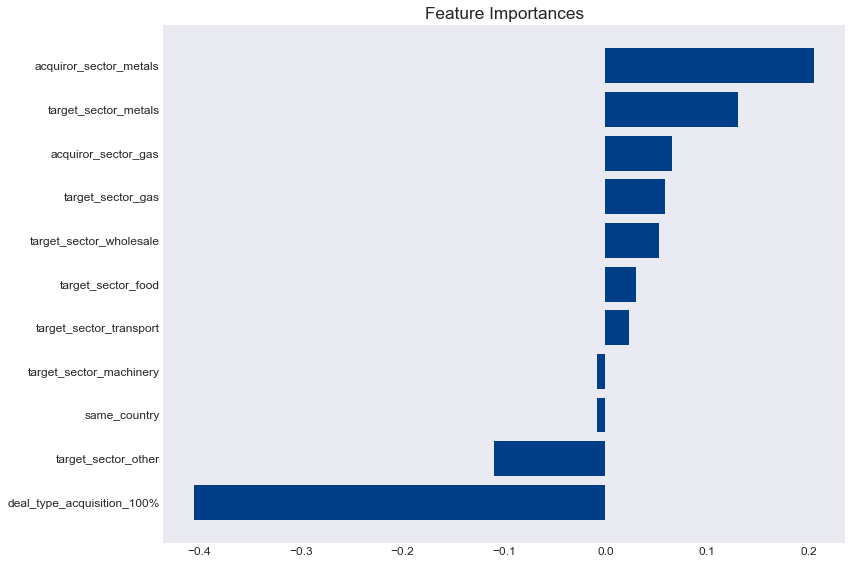

In [179]:
y_ticks = np.arange(0, len(selected_features))
fig, ax = plt.subplots()
ax.barh(y_ticks, sorted(list(classifier.coef_[0]), reverse=False), color='#003F87')
ax.set_yticklabels(selected_features)
ax.set_yticks(y_ticks)
ax.set_title("Feature Importances")
fig.tight_layout()
plt.show()

### all models - best performing configuration

In [180]:
for k, v in model_comparison.items():
    print(f'{k}:')
    print(f"- score {v['score']}")
    print(f"- n features {v['n_features']}")
    print('- features:')
    count = 1
    for x in v['features']:
        print(f'==> {count}: {x}')
        count += 1
    print('')

tree:
- score 0.7168142
- n features 11
- features:
==> 1: deal_type_acquisition_100%
==> 2: target_sector_other
==> 3: same_country
==> 4: target_sector_machinery
==> 5: target_sector_transport
==> 6: target_sector_food
==> 7: target_sector_wholesale
==> 8: target_sector_gas
==> 9: acquiror_sector_gas
==> 10: target_sector_metals
==> 11: acquiror_sector_metals

svm:
- score 0.6902655
- n features 13
- features:
==> 1: deal_type_acquisition_100%
==> 2: roa_target
==> 3: target_sector_other
==> 4: same_sector
==> 5: same_country
==> 6: initial_stake
==> 7: target_sector_chemicals
==> 8: target_sector_machinery
==> 9: target_sector_transport
==> 10: target_sector_food
==> 11: target_sector_wholesale
==> 12: target_sector_gas
==> 13: acquiror_sector_gas

lg:
- score 0.699115
- n features 17
- features:
==> 1: deal_type_acquisition_100%
==> 2: roa_target
==> 3: target_sector_other
==> 4: same_sector
==> 5: acquiror_sector_primary
==> 6: same_country
==> 7: initial_stake
==> 8: target_secto